In [ ]:
# http://forums.fast.ai/t/load-ulmfit-model/17209

In [ ]:
import pandas as pd
import numpy as np
import sys
import html

# Fast-ai path
import sys
sys.path.append("../fastaiDL/fastai/courses/dl2")
from fastai.text import *

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
# our own file with functions
from data_helpers import *

In [4]:
# For Tokenizing
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
PATH=Path('.')
CLAS_PATH=Path('work/clas/')
LM_PATH = Path('work/lm/')

In [10]:
#targetfile = 'final_test.csv'
#targetfile = 'test2000.csv'

targetfile = 'final_test15718entity.csv'

itos_path =  Path('work/saved/lm_fulldata_noent/itos.pkl')

model_file = 'clas_2_Classifier_fullLM_full'
model_fileh5= Path('work/saved/lm_fulldata_noent/clas_2_Classifier_fullLM_full.h5')


# Tokenize
chunksize=24000
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
df_test = pd.read_csv(CLAS_PATH/targetfile, header=None, chunksize=chunksize)

tokens_test, test_labels = get_all(df_test, 1)

(CLAS_PATH/'tmp').mkdir(exist_ok=True)
np.save(CLAS_PATH/'tmp'/'tok_test.npy', tokens_test)
np.save(CLAS_PATH/'tmp'/'test_labels.npy', test_labels)

0


In [11]:
targetfile

'final_test15718entity.csv'

In [13]:
# sanity check - text is readable and classes numbered
df_test2 = pd.read_csv(CLAS_PATH/targetfile, header=None)
df_test2.head(6)

,0,1
0,4,ENTITY Samsung Electronics Q4 operating profit...
1,0,Deutsche Bank Records Said to Show Silver Rigg...
2,0,ENTITY Toshiba Warns Solvency In Jeopardy Afte...
3,0,ENTITY Apple acts on iPhone battery troubles\n...
4,4,ENTITY Apple Music claims 20m paying subscribe...
5,0,Valeant sells $2B in assets to begin paying do...


In [14]:
df_test2.iloc[0][1]

'ENTITY Samsung Electronics Q4 operating profit jumps 50.2% despite Note 7 debacle\nSeoul:\nElectronics\' profits leaped in the fourth quarter, it said on Tuesday, despite the humiliating\nrecall that hammered the reputation of the world\'s largest\nmaker.\nThe South Korean tech giant took another blow when prosecutors began investigating its involvement in a corruption scandal, which has seen the country\'s president impeached, and sought the arrest of the firm\'s de facto leader Lee Jae-Yong.\nIn a statement, the group\'s flagship subsidiary ENTITY Samsung Electronics said it posted operating profits of 9.22 trillion won (US$7.9 billion) during the October to December period, up 50.2% year-on-year. Net profits for the quarter were 7.09 trillion won, up 120%.\nEarnings were “driven by the components businesses, mainly the memory business and the display panel segment", it said, with the stronger US dollar also boosting profits.\nAnalysts say memory chip prices have been driven up by s

In [15]:
df_test2.iloc[213][1]

'ENTITY Boeingeing Stock Is Losing Altitude — Abort!\nENTITY Boeing appears to be on the verge of a technical breakdown, which would end a five-month uptrend for the Dow Jones Industrial Average stalwart as it continues to test support at its 20-day moving average.\nThe stochastic indicator has already flashed a sell signal, falling out of an overbought condition after setting a lower high. Momentum is waning.\nWatch for a break of the 50-day moving average after the company reports results on Jan. 25 before the market. Analysts are looking for earnings of $2.33 per share on revenues of $23.1 billion.\nThe company was recently initiated with an “underperform” rating by analysts at RBC Capital Markets, citing a historical relationship between the company’s profit margins and the average age of its production platforms. According to analyst Matthew McConnell:\n“We believe new commercial platforms create margin pressure due to higher unit production costs in initial accounting blocks, eng

In [16]:
# saving and loading these changes structure from list to np.ndarray
tokens_test = np.load(CLAS_PATH/'tmp'/'tok_test.npy')
len(tokens_test), len(test_labels)

(2000, 2000)

In [17]:
#tokens_test[0]

In [18]:
# String-to-integer 

#itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
#itos_path = Path('work/saved/lm_fulldata_entity/itosMax.pkl')
itos = pickle.load((itos_path).open('rb'))

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocsize = len(itos)

test_clas = np.array([[stoi[o] for o in p] for p in tokens_test])
#??
test_clas = np.expand_dims(test_clas, axis=1)

np.save(CLAS_PATH/'tmp'/'test_ids.npy', test_clas)

In [19]:
test_clas = np.load(CLAS_PATH/'tmp'/'test_ids.npy')
test_clas = np.squeeze(test_clas) 
test_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'test_labels.npy'))
n_class=int(test_labels.max())+1

In [20]:
len(test_labels)

2000

In [21]:
bs = 14
#build TextDataSet
test_dataset = TextDataset(test_clas, test_labels)

# build sortSampler
test_sampler = SortSampler(test_clas, key=lambda x: len(test_clas[x]))

# build DataLoader
# shuffle mixes labels wrongly
#test_loader = DataLoader(test_dataset, bs, transpose=True, num_workers=1, pad_idx=1, sampler=test_sampler)

test_loader = DataLoader(test_dataset, bs, transpose=True, num_workers=1, pad_idx=1, 
                         sampler=None, shuffle=False)

# build TextData
# TextData or fastai.nlp were not used when training mdoel
from fastai.nlp import TextData
md = TextData(PATH, None, test_loader)

In [22]:
# Build classifier - EXACTLY SAME PARAMETERS AS USED WHEN TRAINING!
from functools import partial
from fastai.learner import optim
#opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
#bptt = 70     # back propogation through time
#em_sz = 400   # size of embeddings
#nhiddenu = 1150     # size of hidden
#nlayers = 3        # number of layers

bptt,em_sz,nhiddenu,nlayers = 70,400,1150,3
vocsize = len(itos)
optim_fn = partial(optim.Adam, betas=(0.8, 0.99))

bs = 40

dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

model = get_rnn_classifier(bptt, 20*70, n_class, vocsize, emb_sz=em_sz, n_hid=nhiddenu, n_layers=nlayers, pad_token=1,
          layers=[em_sz*3, 50, n_class], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

learner = RNN_Learner(
    data=md,
    models=TextModel(to_gpu(model)),    
    opt_fn=optim_fn
)

In [ ]:
# load MODEL - saved weights

#model_file = Path('work/saved/lm_fulldata_entity/clas_2_Classifier_ent_full_full')
#model_fileh5= Path('work/saved/lm_fulldata_entity/clas_2_Classifier_ent_full_full.h5')

import torch
from os.path import join
#loaded_weights = torch.load(join(PATH, "models/"+modelfile))
#learner.load(modelfile2)

loaded_weights = torch.load(model_fileh5)
learner.load(model_file)

# confirmed that the new parameters match those of the loaded model
for k,v in loaded_weights.items():
    #print(k, np.all(v == learner.model.state_dict()[k]))
    assert( np.all(v == learner.model.state_dict()[k]))

In [35]:
# try high for faster
bs=14 
bs = 130

### Get predictions

In [36]:
# predict_with_targs gives both predictions and true Labels
# preds_dist is yhat as softmax, preds is real labels

preds_dist, true_labels = learner.predict_with_targs()
#preds_dist, preds = learner.predict_with_targs(is_test=True, use_swa=False) 

In [37]:
# highest class from softmax
yhat = np.argmax(preds_dist, axis=1)

In [38]:
yhat[0:10]

array([1, 0, 0, 1, 1, 1, 4, 1, 3, 3])

#### Total examples, nr correctly predicted, percentage correctly predicted

In [39]:
print(len(test_labels))
print(sum(yhat==true_labels))
print(sum(yhat==true_labels) / len(true_labels))

2000
1686
0.843


### Confusion matrix of mis-predicted

[[500  85   0   5   2]
 [ 17 338   0   6   4]
 [  5  17  11   8   0]
 [  1  53   1 560  24]
 [  9  39   0  38 277]]


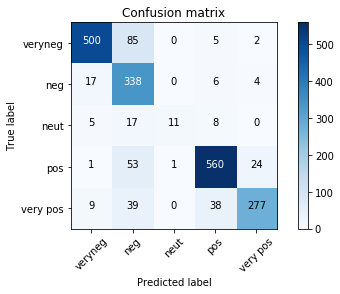

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, yhat)
CLASSES = ['veryneg', 'neg', 'neut', 'pos', 'very pos']
plot_confusion_matrix(cm, CLASSES)

### Error analysis

In [43]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [44]:
softmax(preds_dist[0])

array([0.28343, 0.62961, 0.00828, 0.04405, 0.03463], dtype=float32)

In [45]:
df_preds = pd.DataFrame(preds_dist)
probs = df_preds.apply(softmax, axis=1)

In [ ]:
probs[0:5]

#### Find items with biggest difference in True label and predicted

In [48]:
# SIZE of error - |pred class - true class|
error_amounts = pd.DataFrame( abs(yhat - true_labels) )
#error_amounts[0:4]

#### Biggest error is 4, either True Class 0, predicted 4, or opposite. There are 11 such examples 

In [49]:
max = int(error_amounts.max())
print(max)
sum(error_amounts[0]==max)

4


11

In [64]:
idx_max = error_amounts[0]==4

In [65]:
# Their id:s
idx_max[idx_max==True]

149     True
213     True
532     True
608     True
887     True
1037    True
1148    True
1266    True
1568    True
1616    True
1770    True
Name: 0, dtype: bool

#### As articles are integers, int marking each word, to read them we need to turn ints back to words

In [53]:
# single
# [itos[o] for o in test_clas[0]]

# whole array
articles = np.array( [  [itos[o] for o in article] for article in test_clas ] )

In [55]:
test = articles[idx_max]
test[0]

['\n',
 'xbos',
 'xfld',
 '1',
 't_up',
 'entity',
 'tyson',
 'foods',
 'quarterly',
 'profit',
 'jumps',
 '28.6',
 '%',
 '\n ',
 't_up',
 'entity',
 'tyson',
 'foods',
 ',',
 'the',
 'biggest',
 'u.s',
 '.',
 'meat',
 'processor',
 ',',
 'reported',
 'a',
 '28.6',
 'percent',
 'rise',
 'in',
 'quarterly',
 'profit',
 ',',
 'helped',
 'by',
 'higher',
 'exports',
 'of',
 'beef',
 'and',
 'pork',
 'and',
 'lower',
 'livestock',
 'costs',
 '.',
 '\n',
 'net',
 'income',
 'attributable',
 'to',
 't_up',
 'entity',
 'tyson',
 'foods',
 'rose',
 'to',
 '$',
 '593',
 'million',
 ',',
 'or',
 '$',
 '1.59',
 'per',
 'share',
 ',',
 'in',
 'the',
 'first',
 'quarter',
 'ended',
 'dec',
 '.',
 '31',
 ',',
 'from',
 '$',
 '461',
 'million',
 ',',
 'or',
 '$',
 '1.15',
 'per',
 'share',
 ',',
 'a',
 'year',
 'earlier',
 '.',
 '\n',
 'sales',
 'rose',
 'marginally',
 'to',
 '$',
 '9.18',
 'billion',
 'from',
 '$',
 '9.15',
 'billion',
 '.',
 '\n ',
 't_up',
 'entity',
 'tyson',
 'foods',
 "'s",
 's

In [57]:
def asText(text):
    ''' given sentence of integers return sentence of words responding those integers'''
    text2 = [itos[o] for o in text] # integers to words
    text3 = ' '.join(word for word in text2) # join list of words to one string
    return text3

In [58]:
asText(test_clas[0])

'\n xbos xfld 1 t_up entity samsung electronics q4 operating profit jumps 50.2 % despite note 7 debacle \n seoul : \n electronics \' profits leaped in the fourth quarter , it said on tuesday , despite the humiliating \n recall that hammered the reputation of the world \'s largest \n maker . \n the south korean tech giant took another blow when prosecutors began investigating its involvement in a corruption scandal , which has seen the country \'s president impeached , and sought the arrest of the firm \'s de facto leader lee jae - yong . \n in a statement , the group \'s flagship subsidiary t_up entity samsung electronics said it posted operating profits of 9.22 trillion won ( us$7.9 billion ) during the october to december period , up 50.2 % year - on - year . net profits for the quarter were 7.09 trillion won , up 120 % . \n earnings were “ driven by the components businesses , mainly the memory business and the display panel segment " , it said , with the stronger us dollar also boo

In [44]:
# single article
' '.join(word for word in articles[0])

'\n xbos xfld 1 t_up entity samsung electronics q4 operating profit jumps 50.2 % despite note 7 debacle \n seoul : \n electronics \' profits leaped in the fourth quarter , it said on tuesday , despite the humiliating \n recall that hammered the reputation of the world \'s largest \n maker . \n the south korean tech giant took another blow when prosecutors began investigating its involvement in a corruption scandal , which has seen the country \'s president impeached , and sought the arrest of the firm \'s de facto leader lee jae - yong . \n in a statement , the group \'s flagship subsidiary t_up entity samsung electronics said it posted operating profits of 9.22 trillion won ( us$7.9 billion ) during the october to december period , up 50.2 % year - on - year . net profits for the quarter were 7.09 trillion won , up 120 % . \n earnings were “ driven by the components businesses , mainly the memory business and the display panel segment " , it said , with the stronger us dollar also boo

In [59]:
# whole array
articles2 = [ ' '.join(word for word in row) for row in articles ]

In [79]:
articles2[149]

"\n xbos xfld 1 t_up entity tyson foods quarterly profit jumps 28.6 % \n  t_up entity tyson foods , the biggest u.s . meat processor , reported a 28.6 percent rise in quarterly profit , helped by higher exports of beef and pork and lower livestock costs . \n net income attributable to t_up entity tyson foods rose to $ 593 million , or $ 1.59 per share , in the first quarter ended dec . 31 , from $ 461 million , or $ 1.15 per share , a year earlier . \n sales rose marginally to $ 9.18 billion from $ 9.15 billion . \n  t_up entity tyson foods 's shares were up 7.8 percent at $ 70.50 in premarket trading on monday . \n ( reporting by sruthi ramakrishnan in bengaluru ; editing by sriraj kalluvila )"

In [74]:
type(articles2)

list

In [75]:
art = pd.DataFrame(articles2)

In [76]:
# Pick those articles where biggest differnece between True and predicted label
art[idx_max]

,0
149,\n xbos xfld 1 t_up entity tyson foods quarter...
213,\n xbos xfld 1 t_up entity ENTITY stock is los...
532,\n xbos xfld 1 t_up entity samsung electronics...
608,\n xbos xfld 1 supreme court favors t_up entit...
887,\n xbos xfld 1 t_up entity samsung electronics...
1037,\n xbos xfld 1 u.s . supreme court leaves gap ...
1148,"\n xbos xfld 1 t_up entity aetna , inc . beats..."
1266,\n xbos xfld 1 what investors did n’t like abo...
1568,\n xbos xfld 1 t_up entity twitter finally hir...
1616,\n xbos xfld 1 t_up entity samsung electronics...


In [77]:
yhat[idx_max]

array([0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0])

In [78]:
true_labels[idx_max]

array([4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4])

In [80]:
art[0][149]

"\n xbos xfld 1 t_up entity tyson foods quarterly profit jumps 28.6 % \n  t_up entity tyson foods , the biggest u.s . meat processor , reported a 28.6 percent rise in quarterly profit , helped by higher exports of beef and pork and lower livestock costs . \n net income attributable to t_up entity tyson foods rose to $ 593 million , or $ 1.59 per share , in the first quarter ended dec . 31 , from $ 461 million , or $ 1.15 per share , a year earlier . \n sales rose marginally to $ 9.18 billion from $ 9.15 billion . \n  t_up entity tyson foods 's shares were up 7.8 percent at $ 70.50 in premarket trading on monday . \n ( reporting by sruthi ramakrishnan in bengaluru ; editing by sriraj kalluvila )"

In [81]:
art[0][213]

'\n xbos xfld 1 t_up entity ENTITY stock is losing altitude — abort ! \n  t_up entity boeing appears to be on the verge of a technical breakdown , which would end a five - month uptrend for the dow jones industrial average stalwart as it continues to test support at its 20-day moving average . \n the ENTITY indicator has already flashed a sell signal , falling out of an overbought condition after setting a lower high . momentum is waning . \n watch for a break of the 50-day moving average after the company reports results on jan . 25 before the market . analysts are looking for earnings of $ 2.33 per share on revenues of $ 23.1 billion . \n the company was recently initiated with an “ underperform ” rating by analysts at t_up rbc capital markets , citing a historical relationship between the company ’s profit margins and the average age of its production platforms . according to analyst matthew mcconnell : \n “ we believe new commercial platforms create margin pressure due to higher un